In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#### Seeds Random para Tensorflow y Numpy

In [2]:
tf.random.set_seed(123)
np.random.seed(123)

#### Dataset de Consumo

In [3]:
df_importacion = pd.read_csv('./df_importacion.csv', index_col='Fecha', parse_dates=True)

#### Normalización de los datos | Primer Modelo: Diesel (Consumo)

In [4]:
ts = df_importacion['Diesel'].astype(float)          # barriles
ts_log = np.log(ts)
ts_log_diff = ts_log.diff().dropna()             # d=1

#### Serie de tiempo de Diesel (Consumo)

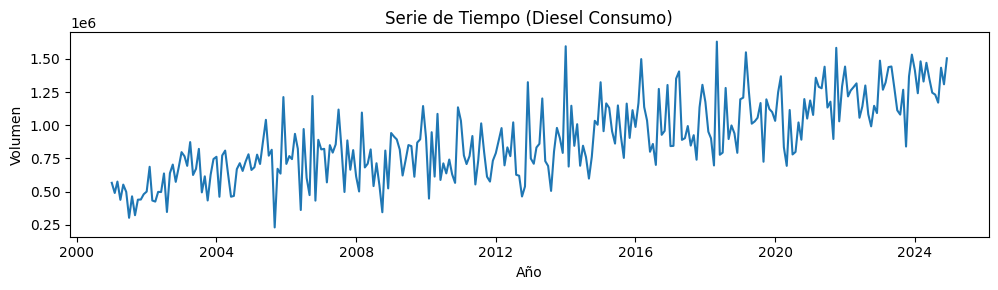

In [5]:
plt.figure(figsize=(10,3))
plt.plot(ts)
plt.title("Serie de Tiempo (Diesel Consumo)")
plt.xlabel("Año"); plt.ylabel("Volumen")
plt.tight_layout(); plt.show()


#### Vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media

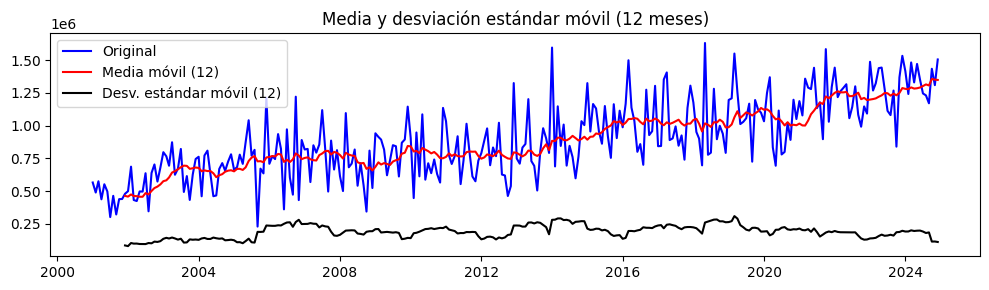

In [6]:
mediaMovil = ts.rolling(window=12).mean()
deMovil    = ts.rolling(window=12).std()

plt.figure(figsize=(10,3))
plt.plot(ts, label="Original", color="blue")
plt.plot(mediaMovil, label="Media móvil (12)", color="red")
plt.plot(deMovil, label="Desv. estándar móvil (12)", color="black")
plt.legend(loc='best')
plt.title("Media y desviación estándar móvil (12 meses)")
plt.tight_layout(); plt.show()

#### Descomposición Aditiva

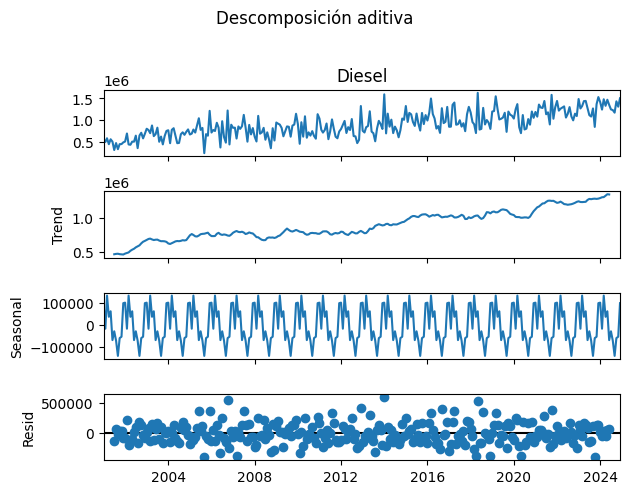

In [7]:
descomp = seasonal_decompose(ts, model='additive')
descomp.plot()
plt.suptitle("Descomposición aditiva", y=1.02)
plt.tight_layout(); plt.show()

#### Prueba Dickey-Fuller Media

In [8]:
print("Resultados del Test de Dickey-Fuller (ADF)")
res = adfuller(ts.dropna(), autolag='AIC')
salida = pd.Series(res[0:4],
                   index=['Estadístico de prueba','p-value',
                          '# retardos usados','# observaciones'])
for k,v in res[4].items():
    salida[f'Critical Value ({k})'] = v
print(salida)

if salida['p-value'] < 0.05:
    print("→ Con p-value < 0.05: rechazamos H0. La serie es ESTACIONARIA en media.")
else:
    print("→ Con p-value ≥ 0.05: NO rechazamos H0. La serie NO es estacionaria en media.")

Resultados del Test de Dickey-Fuller (ADF)
Estadístico de prueba     -0.639188
p-value                    0.861879
# retardos usados         13.000000
# observaciones          274.000000
Critical Value (1%)       -3.454444
Critical Value (5%)       -2.872147
Critical Value (10%)      -2.572422
dtype: float64
→ Con p-value ≥ 0.05: NO rechazamos H0. La serie NO es estacionaria en media.


#### ¿Estacionalidad en Varianza?

In [9]:
win = 36  # meses
var_ini = ts.iloc[:win].var()
var_fin = ts.iloc[-win:].var()

ratio = abs(var_fin - var_ini) / var_ini
print(f"\nVarianza inicial: {var_ini:,.2f} | Varianza final: {var_fin:,.2f} | Cambio relativo: {ratio:.2%}")

if ratio < 0.20:
    print("→ La varianza parece aproximadamente constante (estacionaria en varianza).")
else:
    print("→ La varianza cambia de forma importante. No es estacionaria en varianza.")


Varianza inicial: 20,233,346,876.25 | Varianza final: 25,749,924,920.79 | Cambio relativo: 27.26%
→ La varianza cambia de forma importante. No es estacionaria en varianza.


#### Función para supervisar

In [10]:
def to_supervised(series, lookback=12):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

def invert_log_diff(base_logs, diffs):
    """base_logs y diffs deben tener mismo largo.
       base_logs: log(y_{t-1}), diffs: Δlog(y_t)=log(y_t)-log(y_{t-1})"""
    vals = np.exp(base_logs + diffs.reshape(-1))
    return vals

#### Split en train / val / test

In [11]:
lookback = 12
X_all, y_all = to_supervised(ts_log_diff.values.reshape(-1,1), lookback)

n = len(X_all)
n_train = int(n*0.7)
n_val   = int(n*0.15)

X_train, y_train = X_all[:n_train], y_all[:n_train]
X_val,   y_val   = X_all[n_train:n_train+n_val], y_all[n_train:n_train+n_val]
X_test,  y_test  = X_all[n_train+n_val:], y_all[n_train+n_val:]

#### Scaling y Reshape

In [12]:
sc_X = StandardScaler()
sc_y = StandardScaler()

X_train_2d = X_train.reshape(X_train.shape[0], -1)   # (samples, lookback*features)
X_val_2d   = X_val.reshape(X_val.shape[0], -1)
X_test_2d  = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = sc_X.fit_transform(X_train_2d)
X_val_scaled   = sc_X.transform(X_val_2d)
X_test_scaled  = sc_X.transform(X_test_2d)

y_train_scaled = sc_y.fit_transform(y_train)
y_val_scaled   = sc_y.transform(y_val)
y_test_scaled  = sc_y.transform(y_test)

# Reshape back to (samples, timesteps, features=1)
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], lookback, 1)
X_val_scaled   = X_val_scaled.reshape(X_val.shape[0], lookback, 1)
X_test_scaled  = X_test_scaled.reshape(X_test.shape[0], lookback, 1)

#### Modelos LSTM

##### Modelo #1

In [13]:
model = Sequential([
    LSTM(64, input_shape=(lookback,1)),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[es],
    verbose=1
)

Epoch 1/200


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab02-DS\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.8597 - val_loss: 0.6293
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8366 - val_loss: 0.6157
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8166 - val_loss: 0.6026
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7972 - val_loss: 0.5899
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7780 - val_loss: 0.5777
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7587 - val_loss: 0.5659
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7391 - val_loss: 0.5546
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7191 - val_loss: 0.5440
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6985 - val_loss: 0.5339
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6773 - val_loss: 0.5235
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6555 - val_loss: 0.5109
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6317 - val_loss: 0.4940
E

##### Modelo #2

In [14]:
model1 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    LSTM(32),
    Dense(1)
])
model1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

es1 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history1 = model1.fit(
    X_train_scaled, y_train_scaled,
    epochs=300,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[es],
    verbose=1
)

Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7137 - val_loss: 0.5892
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7038 - val_loss: 0.5872
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6936 - val_loss: 0.5914
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6837 - val_loss: 0.6051
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6764 - val_loss: 0.6007
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6708 - val_loss: 0.5942
Epoch 7/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6641 - val_loss: 0.5901
Epoch 8/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6563 - val_loss: 0.5894
Epoch 9/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6504 - val_loss: 0.5778
Epoch 10/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6420 - val_loss: 0.5834
Epoch 11/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6373 - val_loss: 0.5515
Epoch 12/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

#### Curvas de pérdida

##### Modelo #1

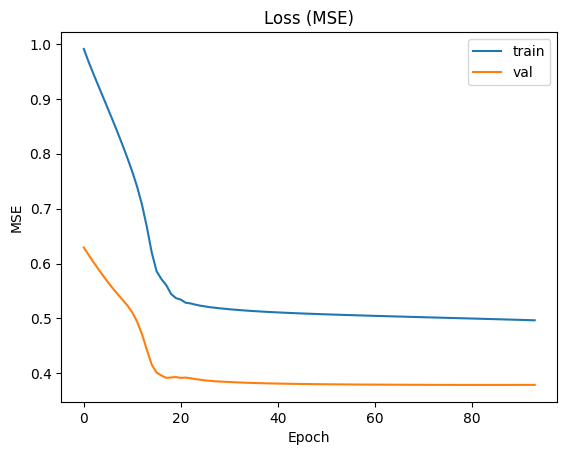

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss (MSE)')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

##### Modelo #2

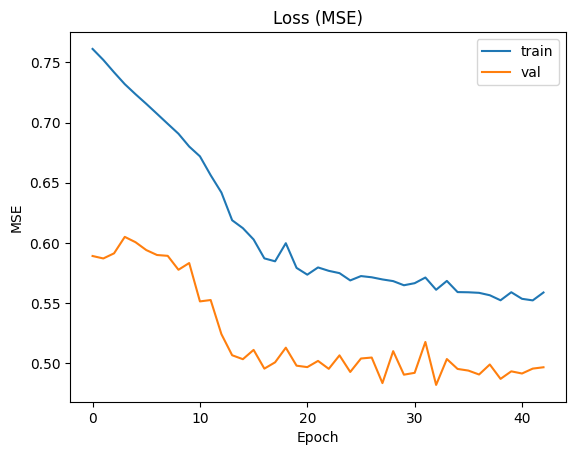

In [16]:
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='val')
plt.title('Loss (MSE)')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

#### Evaluación de los modelos

##### Modelo #1

In [17]:
print("Pérdida en Entrenamiento (Modelo 1)")
model.evaluate(
    x = X_train_scaled,
    y = y_train
)
print("Pérdida en Validación (Modelo 1)")
model.evaluate(
    x = X_val_scaled,
    y = y_val
)
print("Pérdida en Prueba (Modelo 1)")
model.evaluate(
    x = X_test_scaled,
    y = y_test
)

Pérdida en Entrenamiento (Modelo 1)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2856 
Pérdida en Validación (Modelo 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1981
Pérdida en Prueba (Modelo 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0757


0.0722203329205513

##### Modelo #2

In [18]:
print("Pérdida en Entrenamiento (Modelo 2)")
model1.evaluate(
    x = X_train_scaled,
    y = y_train
)
print("Pérdida en Validación (Modelo 2)")
model1.evaluate(
    x = X_val_scaled,
    y = y_val
)
print("Pérdida en Prueba (Modelo 2)")
model1.evaluate(
    x = X_test_scaled,
    y = y_test
)

Pérdida en Entrenamiento (Modelo 2)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4190 
Pérdida en Validación (Modelo 2)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3515
Pérdida en Prueba (Modelo 2)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2032


0.19392044842243195

#### Setup de predicción

In [19]:
def predict_level(modelo, X_scaled, start_idx):
    """start_idx: posición en ts_log del primer target de este bloque"""
    # 1. predicción en escala y_diff
    yhat_scaled = modelo.predict(X_scaled, verbose=0)
    yhat_diff = sc_y.inverse_transform(yhat_scaled)  # Δlog

    # 2. base log (log del último valor de cada ventana)
    #   Para el primer elemento del bloque, el último log está en ts_log[start_idx-1]
    base_logs = []
    for i in range(len(yhat_diff)):
        base_logs.append(ts_log.iloc[start_idx - 1 + i])
    base_logs = np.array(base_logs)

    # 3. revertir diferencia + log
    yhat_level = invert_log_diff(base_logs, yhat_diff)
    return yhat_level

##### Modelo #1 y #2

In [20]:
start_val  = lookback + n_train
start_test = lookback + n_train + n_val

y_val_pred_m1  = predict_level(model,  X_val_scaled,  start_val)
y_test_pred_m1 = predict_level(model,  X_test_scaled, start_test)

y_val_pred_m2  = predict_level(model1, X_val_scaled,  start_val)
y_test_pred_m2 = predict_level(model1, X_test_scaled, start_test)

# Truth (nivel original) para val/test
y_val_true  = ts.iloc[start_val : start_val + len(y_val_pred_m1)].values
y_test_true = ts.iloc[start_test: start_test + len(y_test_pred_m1)].values

#### Métricas y Gráficas de Validación / Predicción

In [21]:
def metrics(y_true, y_pred, name):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f'{name} → RMSE: {rmse:,.0f}  |  MAE: {mae:,.0f} barriles')

##### Modelo #1

In [22]:
metrics(y_val_true,  y_val_pred_m1,  "Val M1")
metrics(y_test_true, y_test_pred_m1, "Test M1")


Val M1 → RMSE: 497,964  |  MAE: 383,542 barriles
Test M1 → RMSE: 369,317  |  MAE: 292,399 barriles


##### Modelo #2

In [23]:
metrics(y_val_true,  y_val_pred_m2,  "Val M2")
metrics(y_test_true, y_test_pred_m2, "Test M2")

Val M2 → RMSE: 480,421  |  MAE: 380,323 barriles
Test M2 → RMSE: 366,577  |  MAE: 289,163 barriles


##### Gráfica Modelo 1

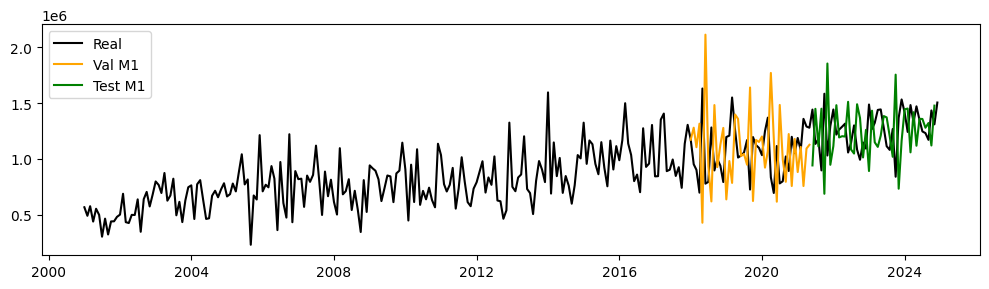

In [24]:
idx_val  = ts.index[start_val : start_val + len(y_val_pred_m1)]
idx_test = ts.index[start_test: start_test + len(y_test_pred_m1)]

plt.figure(figsize=(10,3))
plt.plot(ts, color='black', label='Real')
plt.plot(idx_val,  y_val_pred_m1,  'orange', label='Val M1')
plt.plot(idx_test, y_test_pred_m1, 'green',  label='Test M1')
plt.legend(); plt.tight_layout(); plt.show()

##### Gráfica Modelo #2

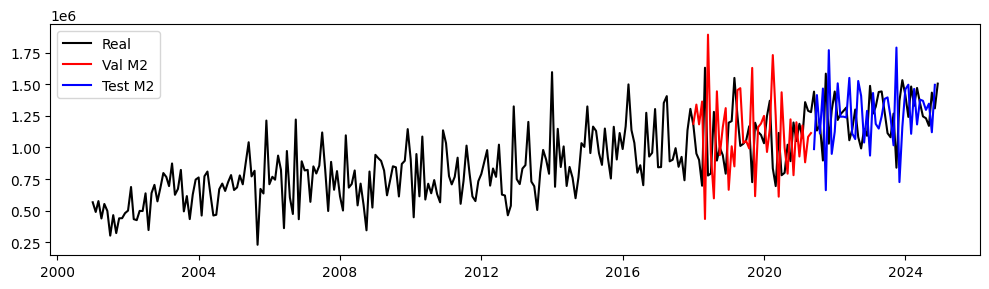

In [25]:
plt.figure(figsize=(10,3))
plt.plot(ts, color='black', label='Real')
plt.plot(idx_val,  y_val_pred_m2,  'red', label='Val M2')
plt.plot(idx_test, y_test_pred_m2, 'blue', label='Test M2')
plt.legend(); plt.tight_layout(); plt.show()